# Counterfactual Prediction with DeepDive

This tutorial demonstrates how to use **DeepDive** for counterfactual prediction in single-cell ATAC-seq data. Specifically, we show how to predict what chromatin accessibility profiles of a held-out cell type (Hepatoblasts) would look like if they had been observed in a particular donor sample.  



In [1]:
import scanpy as sc
import DeepDive
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from utils import reads_to_fragments, rsquared

## 1. Load and preprocess the dataset
We start with an `AnnData` object containing single-cell chromatin accessibility profiles. Here we use the liver [sciATAC-seq3](https://doi.org/10.1126/science.aba7612) dataset (`sciatac3_liver_10k.h5ad`), subset from the full dataset (dataset and preprocessing better described in the `training.ipynb` notebook).

In [3]:
adata = sc.read_h5ad('data/sciatac3_liver_10k.h5ad')

# Filter genes detected in fewer than 1% of cells
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)

# Ensure unique cell IDs
adata.obs_names_make_unique()

# Convert raw reads into fragments
reads_to_fragments(adata)
adata.X = adata.layers['fragments']

## 2. Create a held-out dataset for counterfactual prediction

We hold out **Hepatoblast cells** from one donor (**sample_7_liver**) to use as ground truth for evaluating counterfactual predictions.

In [4]:
adata_ho = adata[(adata.obs['cell_type'].astype(str) == 'Hepatoblasts') & (adata.obs['sample_name'].astype(str) == 'sample_7_liver')].copy()
adata = adata[~adata.obs_names.isin(adata_ho.obs_names)]


## 3. Define model and training parameters

We specify model hyperparameters and training settings.

In [5]:
n_decoders = 5  
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
    'shuffle' : True
}

In [6]:
discrete_covriate_keys = ['sample_name', 'sex', 'batch', 'cell_type']
continuous_covriate_keys = ['day_of_pregnancy']

## 5. Train DeepDive

We initialize and train the model using the training dataset.

In [7]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [8]:
model.train_model(adata, None, 
                  **train_params)

Epoch Train [1500 / 1500]: 100%|██████████| 10/10 [00:00<00:00, 11.20it/s, ETA=01d:00h:20:m53s|01d:00h:20:m53s, kl_loss=1.7, recon_loss=3.2e+3]  


In [9]:
model.save('model')

DeepDIVE model saved at: model


## 6. Reload the trained model

We reload the model for downstream prediction.

In [10]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )
model = model.load(adata, 'model')

## 7. Compute ground truth average profile

We normalize the held-out dataset (`adata_ho`) and compute its average accessibility profile.

In [11]:
sc.pp.normalize_total(adata_ho, target_sum = 10_000)

In [12]:
mean_ho = adata_ho.to_df().mean()

## 8. Predict counterfactuals

We compare three profiles:

- Ground truth (Hepatoblasts from `sample_7`)

- Observed average (all other cell types from `sample_7`)

- Counterfactual prediction (Hepatoblasts predicted by DeepDive in `sample_7`)

In [13]:
# Observed sample 7 (excluding Hepatoblasts)
sample_7 = adata[adata.obs['sample_name'].astype(str) == 'sample_7_liver'].copy()
rec = model.predict(sample_7, library_size=10_000)
mean_no = rec.to_df().mean()

# Counterfactual prediction: force cell_type = Hepatoblasts
sample_7.obs['ct_org'] = sample_7.obs['cell_type'].copy()
sample_7.obs['cell_type'] = 'Hepatoblasts'
rec = model.predict(sample_7, library_size=10_000)
mean_cf = rec.to_df().mean()


## 9. Evaluate counterfactual prediction

We compare the counterfactual predictions against the ground truth and the observed average using scatter plots and R² scores.

Text(0, 0.5, 'All cell average')

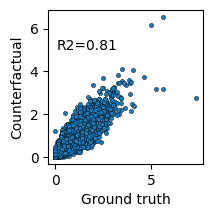

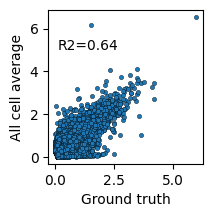

In [14]:
# Counterfactual vs Ground truth
plt.subplots(figsize=(2,2))
sns.scatterplot(x=mean_ho, y=mean_cf, s=10, edgecolor='k')
plt.text(x=0.1, y=5, s=f"R2={round(rsquared(mean_ho, mean_cf), 2)}")
plt.xlabel('Ground truth')
plt.ylabel('Counterfactual')

# Counterfactual vs All-cell average
plt.subplots(figsize=(2,2))
sns.scatterplot(x=mean_no, y=mean_cf, s=10, edgecolor='k')
plt.text(x=0.1, y=5, s=f"R2={round(rsquared(mean_no, mean_cf), 2)}")
plt.xlabel('Ground truth')
plt.ylabel('All cell average')

## Summary

In this tutorial, we:

- Preprocessed an ATAC-seq dataset

- Held out Hepatoblast cells from one donor

- Trained `DeepDive` to disentangle covariates

- Predicted counterfactual accessibility profiles

- Compared predictions to ground truth and donor-wide averages

This demonstrates how DeepDive can be used for counterfactual prediction to study the regulatory landscape of unobserved cell–donor combinations.